<a href="https://colab.research.google.com/github/AimanAminuddin/Variational-Inference-/blob/main/Week_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax 
from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision


import jax.numpy as jnp
import jax.nn
import numpy as np
import pylab as plt

# Exercise: REINFORCE Gradients

Consider the function $L(\lambda) = \int F(\lambda, \theta) \, q_\lambda(\theta) \, d \theta $ where $q_{\lambda}$ refers to a parametric family of distributions Prove that:

$$\nabla_\lambda L(\lambda) =
\int \nabla_\lambda F(\lambda, \theta)  \, q_\lambda(\theta) d \theta + \int F(\lambda, \theta) \, \nabla_\lambda \log[q_{\lambda}(\theta)]  \, q_\lambda(\theta) d \theta$$

Observe that 
\begin{equation}
    \nabla_{\lambda}q_{\lambda}(\theta) = \frac{\nabla_{\lambda}q_{\lambda}(\theta)}{q_{\lambda}(\theta)}q_{\lambda}(\theta) = \nabla \log[q_{\lambda}(\theta)]q_{\lambda}(\theta) 
\end{equation}
It is easy to see that 
\begin{align}
    \nabla_{\lambda}L(\lambda) &= \nabla_{\lambda}\int F(\lambda,\theta)q_{\lambda}(\theta)d\theta \\ 
    &= \int \nabla_{\lambda}\left[F(\lambda,\theta)q_{\lambda}(\theta)\right] d\theta \\ 
    &= \int \nabla_{\lambda} F(\lambda,\theta) q_{\lambda}(\theta) d\theta + \int F(\lambda,\theta)\nabla_{\lambda}q_{\lambda}(\theta)d\theta \\ 
    &= \int \nabla_{\lambda} F(\lambda,\theta) q_{\lambda}(\theta) d\theta + \int F(\lambda,\theta)\nabla_{\lambda} \log[q_{\lambda}(\theta)]q_{\lambda}(\theta) d\theta
\end{align}
by Leibniz rule and chain rule. 

# Exercise: Property of the score function

The quantity $\nabla_\lambda \log[q_{\lambda}(\theta)]$ is often called the score function. Prove that:

$$ \int \nabla_\lambda \log[q_{\lambda}(\theta)]  \, q_\lambda(\theta) d \theta = 0$$


Observe that 
\begin{equation}
 \int \nabla_{\lambda}\log[q_{\lambda}(\theta)]q_{\lambda}(\theta)d\theta = \int \nabla_{\lambda}q_{\lambda}(\theta)d\theta = \nabla_{\lambda} \int q_{\lambda}(\theta)d\theta = \nabla 1 = 0 
\end{equation}

# Exercise: Variational Inference

Use Variational inference and REINFORCE gradidents to find a Gaussian approximation of the density $\pi(x)$ defined as

$$
\pi(x) = \frac{ \exp[ -x^2 + \sin(20 \, x) / 2 ] }{Z}
$$

where $Z>0$ is an unkown normalization constant.

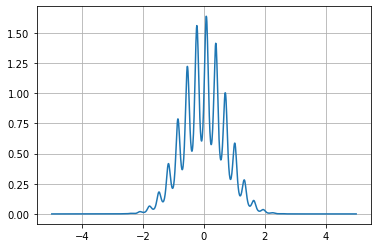

In [2]:
def log_p(x):
    alpha = 0.5
    return -x**2 + alpha * jnp.sin(20*x)

N = 1000
x_arr = np.linspace(-5,5,N)
y_arr = np.exp(log_p(x_arr))
plt.plot(x_arr, y_arr)
plt.grid(True)

The Gaussian Density function is 
\begin{equation}
f(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}
\end{equation}

In [3]:
# lof of Gaussian Approximating Density 
# we calculate log std as numbers generated from np.random can be negative

def log_q(lst,x):
  # lst comtains mean,log_std 
  mu,log_std = lst[0],lst[1] 
  std = jnp.exp(log_std)
  return -(x-mu) ** 2/(2 * (std ** 2))-0.5 * jnp.log(2*jnp.pi*(std ** 2))

def generate_samples(lst,N):
  mu,log_std = lst[0],lst[1]
  std = jnp.exp(log_std)
  return mu + std * np.random.normal(0,1,N)

In [4]:
# vmap everything to use with batch of samples 
log_q_batch = jax.vmap(log_q, in_axes=(None,0))
log_q_grad = jax.grad(log_q)
log_q_grad_batch = jax.vmap(log_q_grad, in_axes=(None,0))

We want to minimize $L(\lambda) = \int F(\lambda,\theta)q_{\lambda}(x)dx $

In [5]:
def F(lst,x):
  # 1/n F(lambda,x) approximately equal to E[F(lambda,x)]
  return log_q(lst,x)-log_p(x)

# vmap everything to use with batch of samples 
F_batch = jax.vmap(F,in_axes = (None,0))
F_grad = jax.grad(F)
F_grad_batch = jax.vmap(F_grad,in_axes = (None,0))

In [6]:
@jax.jit 
def reinforce(lamb,N,xs):
  # compute a reinforce gradient of the loss function 
  # loss = \integral F(lambda,x) * q_l(x)dx 
  Fs = F_batch(lamb,xs)
  F_gradients = F_grad_batch(lamb,xs)
  log_q_gradients = log_q_grad_batch(lamb,xs)
  g0 = jnp.mean(F_gradients,axis = 0)
  # multiply each Fs to gradient appropriately using [:,None]
  g1 = jnp.mean(Fs[:,None] * log_q_gradients,axis = 0)
  grad_reinforce = g0 + g1 
  
  return grad_reinforce

In [7]:
lamb_init = np.array([5., -2.])
N_samples = 100

In [8]:
lamb = np.copy(lamb_init)

In [30]:
N_samples = 1000
learning_rate = 0.04
niter = 100
lamb = np.copy(lamb_init)
loss_history = []
lambda_history = []

for _ in range(niter):
  xs = generate_samples(lamb,N_samples)
  # item() extract value from jax array 
  value = jnp.mean(F_batch(lamb,xs)).item()
  gradient = reinforce(lamb,N_samples,xs) 
  lamb -=  gradient * learning_rate 
  loss_history.append(value) 
  lambda_history.append(np.array(lamb))

In [31]:
print(loss_history) # using approximated estimate, in reality shouldnt fall below 0 

[25.619239335942762, 20.92511643352573, 16.582072483947243, 12.626776347258664, 10.880284539931509, 9.115180850560638, 7.585428932842801, 6.117952075407753, 5.033612737992933, 4.195544201814329, 3.6244390706641907, 3.046965358389082, 2.5927486169529574, 2.21400346176851, 1.8002267790532465, 1.5641262151665882, 1.310384087543071, 1.1056560313376902, 0.9620032476381908, 0.8177626105490214, 0.6073668620606676, 0.5265591042836775, 0.37512891021522643, 0.2860847421361142, 0.21973737457520864, 0.17852745878412782, 0.07464223899467484, 0.0037699175505117285, -0.054800237504379117, -0.1262804799266291, -0.1502775443105187, -0.216302190387571, -0.20724272660131465, -0.23133794207835787, -0.3134281993506221, -0.3450687986333869, -0.3552101771475145, -0.43465515907543895, -0.3774121357611423, -0.4335347089384265, -0.4262421223108658, -0.46561311515744325, -0.4860413441584921, -0.48978456364033945, -0.49593547814933586, -0.5066555291089703, -0.5418466951736193, -0.519676786247399, -0.5139237648444

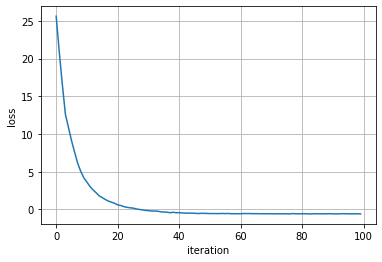

In [32]:
plt.plot(loss_history)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.grid(True)

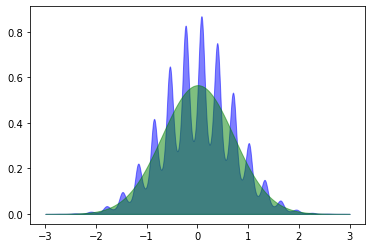

In [35]:
# Draw approximated Gaussian Distribution against true distribution 
N = 1000 
x_arr = np.linspace(-3,3,N)
dx = x_arr[1] - x_arr[0]
y_arr = np.exp(log_p(x_arr))
lamb = lambda_history[-1]
Z = dx * np.sum(y_arr)
y_arr = y_arr / Z

# Posterior Distribution 
plt.fill_between(x_arr,y_arr,[0 for _ in y_arr],alpha = 0.5,color = "blue",label = "Posterior Distribution")


# Variational Approximation 
q_arr = np.exp(log_q_batch(lamb,x_arr))
plt.fill_between(x_arr,q_arr,[0 for _ in q_arr],alpha = 0.5,color = "green",label = "Variational Approximation")
